In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG, Audio
from keras.layers import Dropout
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-05-04 21:49:10.534424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chrispv/miniconda3/envs/tf-LSTM/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
2023-05-04 21:49:12.765475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 21:49:12.788222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus

In [2]:
datasetPath = "../datasets"

In [3]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

In [5]:
directory = f"{datasetPath}/spectrogramsAlt3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrogramsAlt3sec/test/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,f"{datasetPath}/spectrogramsAlt3sec/test/" + f"{g}")


In [6]:
train_dir = f"{datasetPath}/spectrogramsAlt3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = f"{datasetPath}/spectrogramsAlt3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [7]:
def GenreModel(input_shape = (288,432,4),classes=10):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
# checkpoint_path = "saved_cnn2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

model = GenreModel(input_shape=(288,432,4), classes=10)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

2023-05-04 21:49:13.749632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 21:49:13.751260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 21:49:13.751635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 21:49:13.751961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_nod

In [9]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

In [10]:
if os.path.exists("saved/saved_cnn12_3.h5"):
    model_history = model.load_model("saved/saved_cnn12_3.h5")
else:
    model_history = model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)
    model.save("saved/saved_cnn12_3.h5")

/tmp/ipykernel_38698/2285924733.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=70,validation_data=vali_generator)


Epoch 1/70


2023-05-04 21:49:15.877340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 254803968 exceeds 10% of free system memory.
2023-05-04 21:49:17.982606: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 254803968 exceeds 10% of free system memory.
2023-05-04 21:49:18.689580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-04 21:49:19.277494: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 254803968 exceeds 10% of free system memory.
2023-05-04 21:49:24.600393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 3/71 [>.............................] - ETA: 53s - loss: 5.1984 - accuracy: 0.1406 - get_f1: 0.1021 

2023-05-04 21:49:27.047475: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 254803968 exceeds 10% of free system memory.


 4/71 [>.............................] - ETA: 1:02 - loss: 5.0280 - accuracy: 0.1348 - get_f1: 0.0924

2023-05-04 21:49:28.390184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 254803968 exceeds 10% of free system memory.


71/71 [==============================] - 96s 1s/step - loss: 2.3824 - accuracy: 0.2843 - get_f1: 0.2160 - val_loss: 2.4926 - val_accuracy: 0.1360 - val_get_f1: 0.0000e+00
Epoch 2/70
71/71 [==============================] - 86s 1s/step - loss: 1.4522 - accuracy: 0.4893 - get_f1: 0.4600 - val_loss: 3.5660 - val_accuracy: 0.1010 - val_get_f1: 0.1035
Epoch 3/70
71/71 [==============================] - 83s 1s/step - loss: 1.1353 - accuracy: 0.6046 - get_f1: 0.5877 - val_loss: 5.4008 - val_accuracy: 0.1070 - val_get_f1: 0.1056
Epoch 4/70
71/71 [==============================] - 82s 1s/step - loss: 0.9165 - accuracy: 0.6886 - get_f1: 0.6776 - val_loss: 7.1193 - val_accuracy: 0.1000 - val_get_f1: 0.1001
Epoch 5/70
71/71 [==============================] - 81s 1s/step - loss: 0.8308 - accuracy: 0.7154 - get_f1: 0.7072 - val_loss: 7.7506 - val_accuracy: 0.1000 - val_get_f1: 0.0987
Epoch 6/70
71/71 [==============================] - 81s 1s/step - loss: 0.6981 - accuracy: 0.7606 - get_f1: 0.7583 - 

Text(0, 0.5, 'Accuracy [%]')

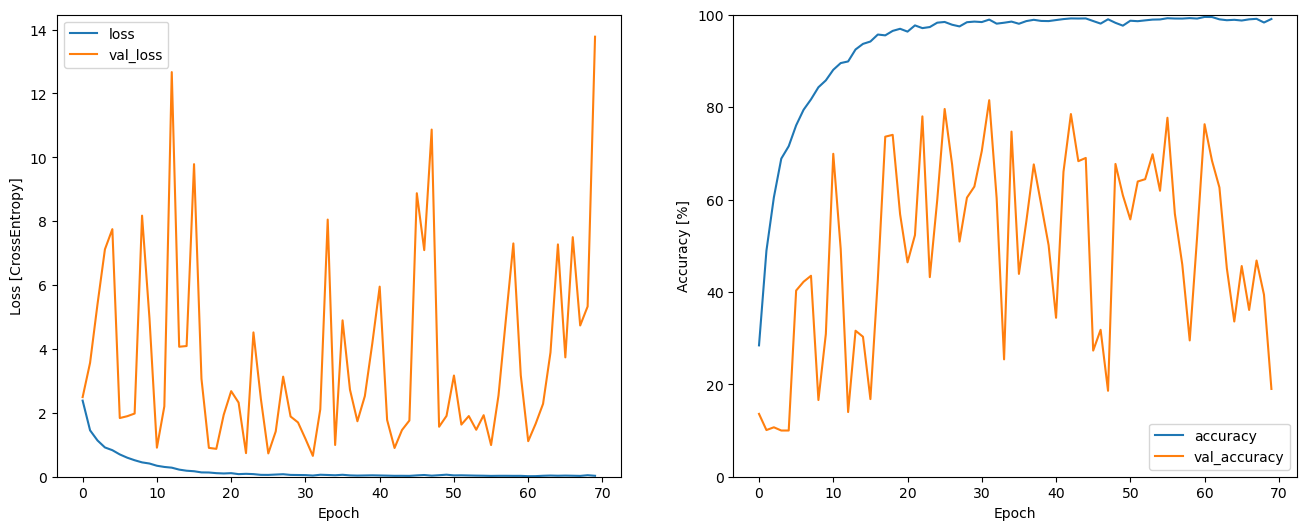

In [11]:
metrics = model_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(model_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [12]:
test_loss, test_acc, _ = model.evaluate(vali_generator, batch_size=128)
print("The test Loss is :", test_loss)
print("\nThe Best test Accuracy is :", test_acc*100)

8/8 [==============================] - 8s 972ms/step - loss: 13.7760 - accuracy: 0.1900 - get_f1: 0.1897
The test Loss is : 13.776013374328613

The Best test Accuracy is : 18.99999976158142


In [13]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, genres)
figsize = (12,12)

x, y = zip(*(vali_generator[i] for i in range(len(vali_generator))))
x_val, y_val = np.vstack(x), np.vstack(y)
y_val = np.argmax(y_val, axis=1)

32/32 [==============================] - 1s 12ms/step


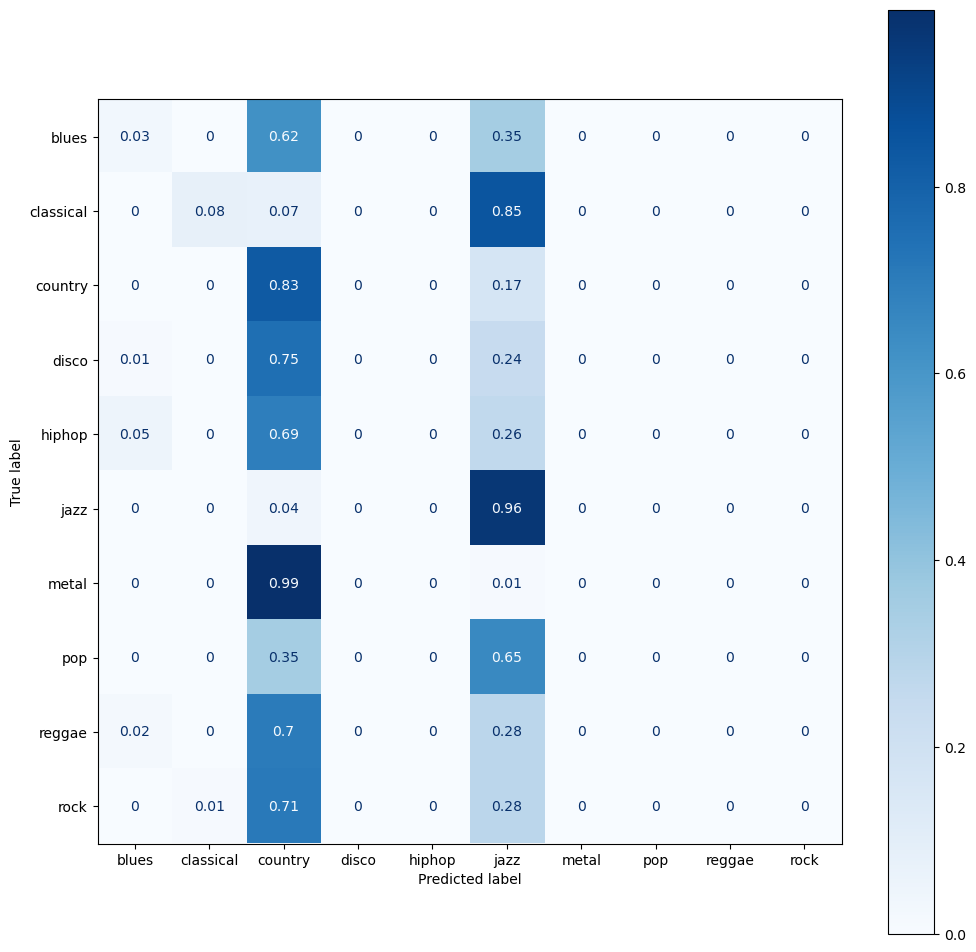

In [14]:
ConfusionMatrixDisplay.from_estimator(classifier, x_val, y_val, cmap='Blues', display_labels=genres ,normalize='true', ax=plt.subplots(figsize=figsize)[1])

In [15]:
import pathlib
input_dir = pathlib.Path("src/input/")
audio_file_name = "chopin.wav"
sample_dir = "src/input/samples/"
audio_seg_dir = "src/input/audio_segments/"

predictions = []

if not input_dir.exists():
    os.mkdir("src/input")
    os.mkdir(sample_dir)
    os.mkdir(audio_seg_dir)

sample, sample_sr = librosa.load(os.path.join(sample_dir, audio_file_name))
sample_duration = int(librosa.get_duration(y=sample, sr=sample_sr))
Audio(sample, rate=sample_sr)

for i in range(int(sample_duration/3)): 
    t1 = i * 3 * 1000 #Works in milliseconds
    t2 = (i+1) * 3 * 1000
    newAudio = AudioSegment.from_wav(os.path.join(sample_dir, audio_file_name))
    newAudio = newAudio[t1:t2]
    newAudio.export(audio_seg_dir + 'audio_seg_' + str(i) +'.wav', format="wav") #Exports to a wav file in the current path.

from keras.utils import load_img, img_to_array

for af in os.listdir(audio_seg_dir):
    audio, sr = librosa.load(os.path.join(audio_seg_dir, af))
    mels = librosa.feature.melspectrogram(y=audio,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))

    spec_dir = "src/input/specs_segments"

    if not os.path.exists(spec_dir):
        os.mkdir(spec_dir)

    plt.savefig(os.path.join(spec_dir, af[:-3] + 'png'))

    image_data = load_img(os.path.join(spec_dir, af[:-3] + 'png'),color_mode='rgba',target_size=(288,432))
    image = img_to_array(image_data)
    image = np.reshape(image,(1,288,432,4))

    p = model.predict(image/255)
    p = p.reshape((10,))

    predictions.append(p)

FileNotFoundError: [Errno 2] No such file or directory: 'src/input'

In [ ]:
avg_preds = [x / len(predictions) for x in np.array(predictions).sum(axis=0)]
predicted_label = np.argmax(avg_preds)

print("The Predicted Label was: " + genres[predicted_label])

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(genres, np.array(avg_preds))
plt.title("Inference Results")
plt.show()